# Analyse data distributions

This notebook is made to analyse the distribution of each explanatory variable regarding our tennis data samples

### imports

In [109]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="darkgrid", palette="deep")

### Get Data

In [110]:
path_to_data = "../data"
path_to_processed_data = os.path.join(path_to_data, "processed")
path_df = os.path.join(path_to_processed_data, "tennis_merged.csv") 

In [111]:
df = pd.read_csv(path_df)

### Visualize data

In [112]:
df.coupon_discount.unique()

array([ 0.,  5., 11., 10., 15.,  8.])

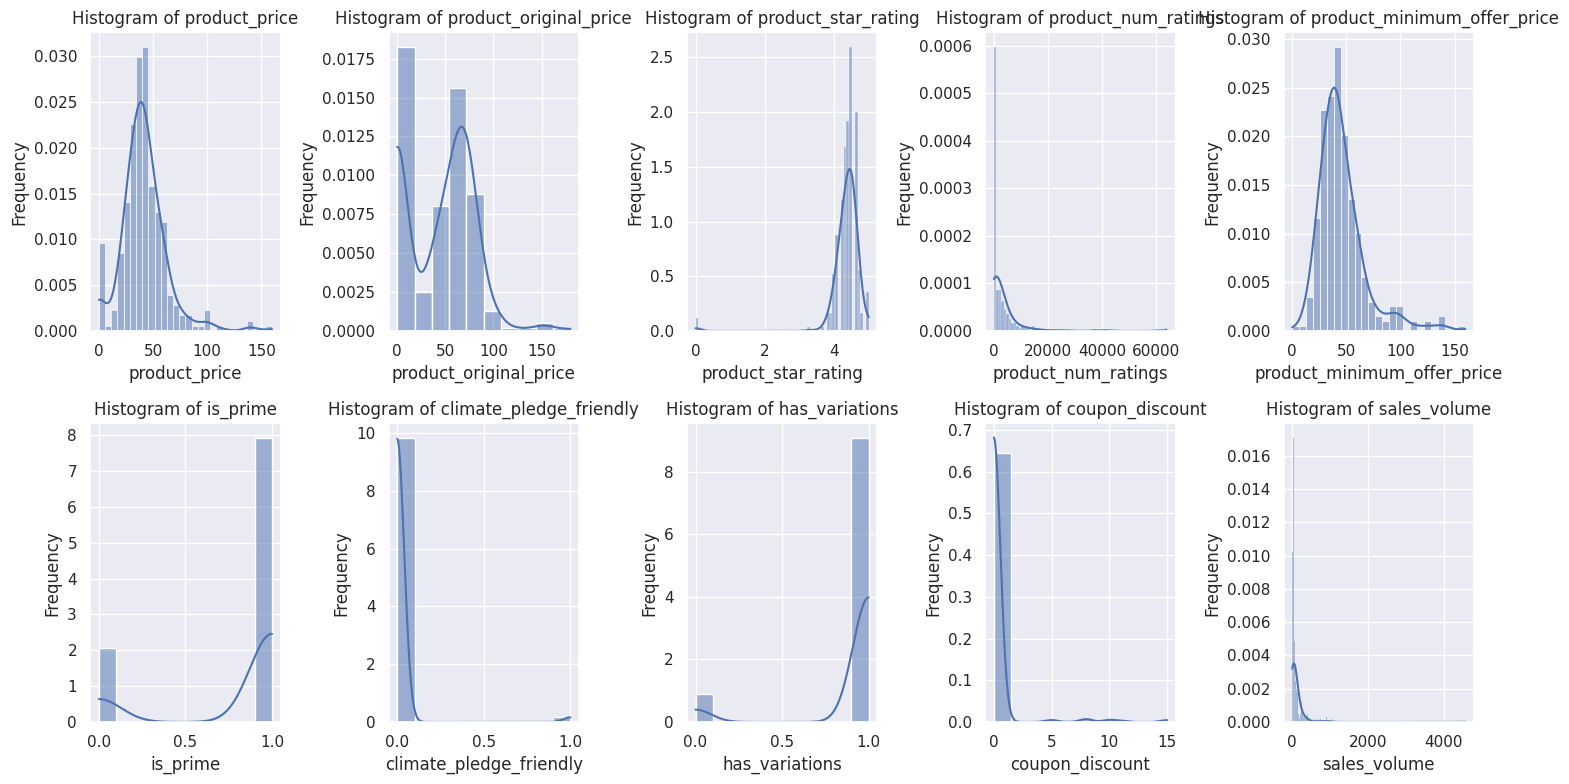

In [113]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # Tamaño ajustado para la cuadrícula
axes = axes.ravel()  # Convertimos los ejes a un array 1D para iterar fácilmente

# Iterar sobre las columnas y graficar los histogramas
for i, column in enumerate(df.select_dtypes(include='number').columns):
    #axes[i].hist(df[column], bins=30, color="b")
    sns.histplot(data=df, x=column, stat="density", ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Eliminar cualquier gráfico vacío (si hay más espacios que columnas)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Hypothesize distributions

In [114]:
hypothesized_distributions = {        
    'product_price': 'non-symmetric bimodal', 
    'product_original_price': 'symmetric bimodal', 
    'product_star_rating': 'normal',
    'product_num_ratings': 'lognormal', 
    'product_minimum_offer_price': 'normal', 
    'is_prime': 'bernouilli',
    'climate_pledge_friendly': 'bernouilli', 
    'has_variations': 'bernouilli', 
    'coupon_discount': 'multinomial',
    'sales_volume': 'lognormal'
}

In [115]:
for variable, distribution in hypothesized_distributions.items():
    print("Hypothesis for the distribuion of {}: {}".format(variable, distribution))
    print("=" * 15)

Hypothesis for the distribuion of product_price: non-symmetric bimodal
Hypothesis for the distribuion of product_original_price: symmetric bimodal
Hypothesis for the distribuion of product_star_rating: normal
Hypothesis for the distribuion of product_num_ratings: lognormal
Hypothesis for the distribuion of product_minimum_offer_price: normal
Hypothesis for the distribuion of is_prime: bernouilli
Hypothesis for the distribuion of climate_pledge_friendly: bernouilli
Hypothesis for the distribuion of has_variations: bernouilli
Hypothesis for the distribuion of coupon_discount: multinomial
Hypothesis for the distribuion of sales_volume: lognormal


## Godness-of-fit tests

In [116]:
from scipy import stats

In [117]:
hypotheses = pd.DataFrame(hypothesized_distributions.items(), columns=["variable_name", "distribution"])
hypotheses.sort_values(by="distribution", inplace=True)

In [118]:
hypotheses["result"] = None

In [138]:
hypotheses

,variable_name,distribution,result
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,True
7,has_variations,bernouilli,True
3,product_num_ratings,lognormal,False
9,sales_volume,lognormal,None
8,coupon_discount,multinomial,None
0,product_price,non-symmetric bimodal,None
2,product_star_rating,normal,False
4,product_minimum_offer_price,normal,False
1,product_original_price,symmetric bimodal,None


In [120]:
from statsmodels.stats.gof import gof_chisquare_discrete
from statsmodels.stats.diagnostic import kstest_fit, normal_ad  

### 1. Bimodal

### 2. Normal

In [121]:
help(normal_ad)

Help on function normal_ad in module statsmodels.stats._adnorm:

normal_ad(x, axis=0)
    Anderson-Darling test for normal distribution unknown mean and variance.
    
    Parameters
    ----------
    x : array_like
        The data array.
    axis : int
        The axis to perform the test along.
    
    Returns
    -------
    ad2 : float
        Anderson Darling test statistic.
    pval : float
        The pvalue for hypothesis that the data comes from a normal
        distribution with unknown mean and variance.
    
    See Also
    --------
    statsmodels.stats.diagnostic.anderson_statistic
        The Anderson-Darling a2 statistic.
    statsmodels.stats.diagnostic.kstest_fit
        Kolmogorov-Smirnov test with estimated parameters for Normal or
        Exponential distributions.



In [122]:
normal_ad(
    x=df["product_star_rating"].to_numpy(),
)

(31.27123351340947, 0.0)

In [123]:
hypotheses.loc[hypotheses["variable_name"]=="product_star_rating", "result"] = False

In [124]:
normal_ad(
    x=df["product_minimum_offer_price"].to_numpy(),
)

(11.731812461639777, 3.313806116552622e-28)

In [125]:
hypotheses.loc[hypotheses["variable_name"]=="product_minimum_offer_price", "result"] = False

### 3. Lognormal

In [126]:
variable = "product_num_ratings"
data = df[variable].to_numpy()

In [127]:
# Ajustar la distribución lognormal
shape, loc, scale = stats.lognorm.fit(data[data > 0], floc=0)  # floc=0 para asegurar que la ubicación sea cero

# Realizar la prueba de Kolmogorov-Smirnov
D, p_value = stats.kstest(data[data > 0], 'lognorm', args=(shape, loc, scale))

In [128]:
p_value

0.07003966240001736

In [129]:
hypotheses.loc[hypotheses["variable_name"]==variable, "result"] = False

### 4. Bernouilli

In [130]:
prob_prime = df["is_prime"].mean()

In [131]:
gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(prob_prime,),
    rvs=df["is_prime"],
    alpha=0.05,
    msg="Is Prime "
)

(7.88860905221012e-31,
 0.9999999999999993,
 True,
 'chisquare - test for Is Prime at arg = (0.7935483870967742,) with pval = 0.9999999999999993')

In [132]:
hypotheses.loc[hypotheses["variable_name"]=="is_prime", "result"] = True

In [133]:
hypotheses

,variable_name,distribution,result
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,None
7,has_variations,bernouilli,None
3,product_num_ratings,lognormal,False
9,sales_volume,lognormal,None
8,coupon_discount,multinomial,None
0,product_price,non-symmetric bimodal,None
2,product_star_rating,normal,False
4,product_minimum_offer_price,normal,False
1,product_original_price,symmetric bimodal,None


In [134]:
# climate pledge

gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(df["climate_pledge_friendly"].mean(),),
    rvs=df["climate_pledge_friendly"].to_numpy(),
    alpha=0.05,    
    msg="Climate Pledge "
)

(3.9443045261050625e-30,
 0.9999999999999984,
 True,
 'chisquare - test for Climate Pledge at arg = (0.016129032258064516,) with pval = 0.9999999999999984')

In [135]:
hypotheses.loc[hypotheses["variable_name"]=="climate_pledge_friendly", "result"] = True

In [136]:
gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(df["has_variations"].to_numpy().mean(), ),
    rvs=df["has_variations"].to_numpy(),
    alpha=0.05,
    msg="Has variations"
)

(4.507776601262924e-31,
 0.9999999999999994,
 True,
 'chisquare - test for Has variationsat arg = (0.9096774193548387,) with pval = 0.9999999999999994')

In [137]:
hypotheses.loc[hypotheses["variable_name"]=="has_variations", "result"] = True

### 5. Multinomial